In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.preprocessing import image
from PIL import Image
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
from time import time
import matplotlib.style as style
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

warnings.filterwarnings('ignore')

# Data preparation

In [2]:
# !git clone https://github.com/MemphisMeng/posters.git

In [52]:
movies = pd.read_csv('movies.csv', engine='python')
movies = movies[['id', 'title', 'genres']]

# genre is empty, for prediction
predict_set = movies[movies['genres'].isna()]
movies = movies[movies['genres'].notna()]

In [53]:
movies['genres'] = movies['genres'].apply(lambda s: [l for l in str(s).split(', ')])
movies['genres']

0         [animation, comedy, family]
1        [adventure, fantasy, family]
2                   [romance, comedy]
3            [comedy, drama, romance]
4                            [comedy]
                     ...             
46621               [science fiction]
46622        [drama, action, romance]
46623                 [drama, family]
46624                         [drama]
46625       [action, drama, thriller]
Name: genres, Length: 44104, dtype: object

In [54]:
# movies' posters can not be found in the image set
for i in movies.index:
    if os.path.exists('posters/train/' + str(movies['id'][i]) + '.jpg') is False:
        movies.drop(i, inplace=True)
        
for i in predict_set.index:
    if os.path.exists('posters/test/' + str(predict_set['id'][i]) + '.jpg') is False:
        predict_set.drop(i, inplace=True)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(movies['id'], movies['genres'], test_size=0.2, random_state=42)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  32213
Number of posters for validation:  8054


In [56]:
X_train = [os.path.join('posters/train/', str(id)+'.jpg') for id in X_train if os.path.exists('posters/train/' + str(id) + '.jpg')]
X_val = [os.path.join('posters/train/', str(id)+'.jpg') for id in X_val if os.path.exists('posters/train/' + str(id) + '.jpg')]
X_train[:3]

['posters/train/256561.jpg',
 'posters/train/118150.jpg',
 'posters/train/47333.jpg']

# Preprocessing

In [57]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['documentary'],
 ['drama', 'comedy', 'crime', 'thriller'],
 ['drama', 'romance']]

In [58]:
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. action
1. adventure
2. animation
3. comedy
4. crime
5. documentary
6. drama
7. family
8. fantasy
9. foreign
10. history
11. horror
12. music
13. mystery
14. romance
15. science fiction
16. thriller
17. tv movie
18. war
19. western


In [59]:
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

for i in range(3):
    print(X_train[i], y_train_bin[i])

posters/train/256561.jpg [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
posters/train/118150.jpg [0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
posters/train/47333.jpg [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


In [60]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [61]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [62]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [63]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [64]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [65]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 20)


# Modeling

In [66]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

# feature_extractor_layer = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), 
#                                                            include_top=False, weights='imagenet')
feature_extractor_layer.trainable = False

In [67]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 20)                20500     
Total params: 3,590,228
Trainable params: 1,332,244
Non-trainable params: 2,257,984
_________________________________________________________________


In [68]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [69]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [70]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [71]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(lr=5e-4),
#     loss=tf.keras.metrics.binary_crossentropy,
#     metrics=[macro_f1])

In [ ]:
start = time()
with tf.device('/device:GPU:0'):
    history = model.fit(train_ds,
                        epochs=EPOCHS,
                        steps_per_epoch=70,
                        validation_data=create_dataset(X_val, y_val_bin),
                       validation_steps=70)
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/30
14/70 [=====>........................] - ETA: 1:24 - loss: 0.8373 - macro_f1: 0.1603

In [ ]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

In [ ]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

# Prediction

In [75]:
def show_prediction(index, movies_df, model):
    
    # Get movie info
    imdbId = movies_df['id'].iloc[index]
    img_path = os.path.join('posters/test/', str(imdbId)+'.jpg')

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.6).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n{}\nGenre Prediction\n{}'.format(movies_df['title'].iloc[index], list(prediction)), fontsize=9)
    plt.show()

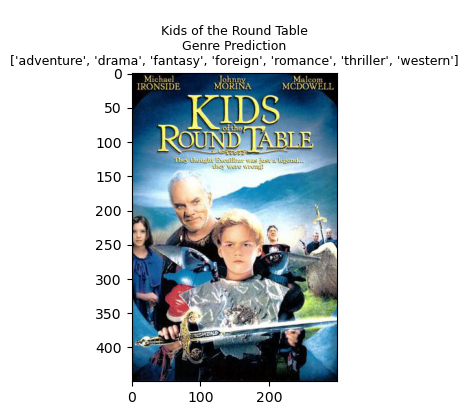

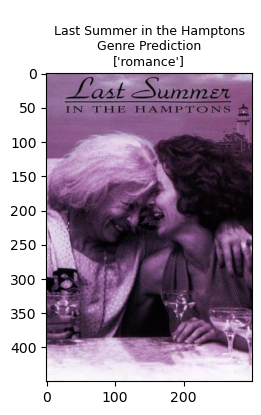

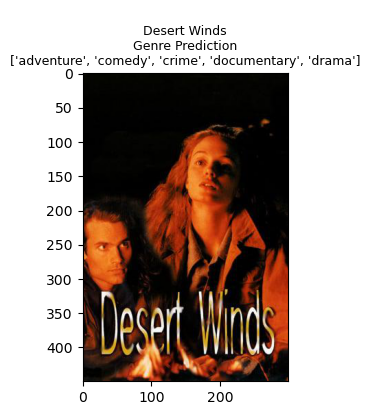

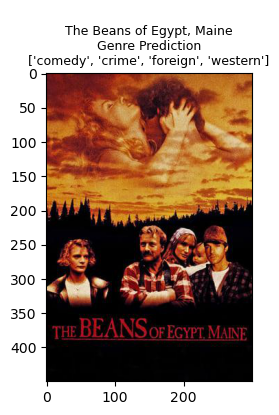

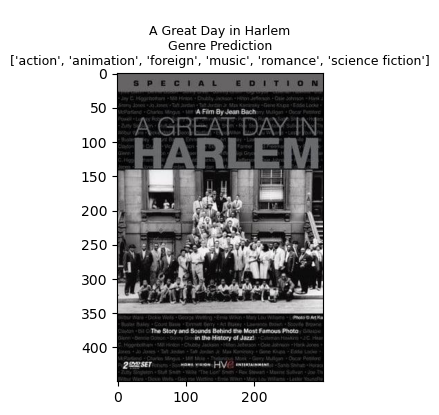

In [76]:
# examples
for i in range(5):
    try:
        show_prediction(i, predict_set, model)
    except FileNotFoundError:
        print('Poster of this movie is not available')